# dbt Project

This is a follow-along project done by Albert Lok to demonstrate use and features of dbt.

Credit to @josephmachado for tutorial and code

The goal of this project is to create a denormalized `table customer_orders`, with information about every order placed by the customers. Let’s assume the customers and orders data are loaded into the warehouse by a process.

The process used to bring these data into our data warehouse is the EL part. This can be done using a vendor service like Fivetran, Stitch, or open-source services like Singer, Airbyte or using a custom service.

Let’s see how our data is transformed into the final denormalized table:

![Data Transformation](https://www.startdataengineering.com/images/dbt_tutorial/data_flow.png)

We will follow data warehouse best practices like having staging tables, testing, using slowly changing dimensions type 2 and naming conventions.

### Clone the git repo and start the data warehouse docker container
```
git clone https://github.com/josephmachado/simple_dbt_project.git
export DBT_PROFILES_DIR=$(pwd)
cd simple_dbt_project
docker compose up -d
```

By default dbt will look for warehouse connections in the file `~/.dbt/profiles.yml`. The `DBT_PROFILES_DIR` environment variable tells dbt to look for the `profiles.yml` file in the current working directory.

In the `simple_dbt_project` folder you will see the following folders.

.

├── analysis

├── data

├── macros

├── models

│   ├── marts

│   │   ├── core

│   │   └── marketing

│   └── staging

├── snapshots

└── tests

`analysis`: Any .sql files found in this folder will be compiled to raw sql when you run `dbt compile`. They will not be run by dbt but can be copied into any tool of choice.

`data`: We can store raw data that we want to be loaded into our data warehouse. This is typically used to store small mapping data.

`macros`: Dbt allows users to create macros, which are sql based functions. These macros can be reused across our project.

## Set the warehouse connections and project settings

1. `profiles.yml`

Dbt requires a `profiles.yml` file to contain data warehouse connection details. We have defined the warehouse connection details at `/simple_dbt_project/profiles.yml`.

The target variable defines the environment. The default is dev. We can have multiple targets, which can be specified when running dbt commands.

The profile is `sde_dbt_tutorial`. The `profiles.yml` file can contain multiple profiles for when you have more than one dbt project.

2. `dbt_project.yml`
In this file, you can define the profile to be used and the paths for different types of files (see `*-paths`).

Materialization is a variable that controls how dbt creates a model. By default, every model will be a view. This can be overridden in `dbt_profiles.yml`. We have set the models under `models/marts/core/` to materialize as tables.

```
# Configuring models
models:
    sde_dbt_tutorial:
        # Applies to all files under models/marts/core/
        marts:
            core:
                materialized: table
```

## Data Flow

We will see how the customer_orders table is created from the source tables. These transformations follow warehouse and dbt best practices.

1. Source
Source tables refer to tables loaded into the warehouse by an EL process. Since dbt did not create them, we have to define them. This definition enables referring to the source tables using the source function. For e.g. `{{ source('warehouse', 'orders') }}` refers to the `warehouse.orders` table. We can also define tests to ensure that the source data is clean.

Source definition: `sde_dbt_tutorial/models/staging/src_eltool.yml`
Test definitions: `sde_dbt_tutorial/models/staging/src_eltool.yml`

2. Snapshots
A business entity’s attributes change over time. These changes should be captured in our data warehouse. E.g. a user may move to a new address. This is called slowly changing dimensions, in data warehouse modeling.

Dbt allows us to easily create these slowly changing dimension tables (type 2) using the snapshot feature. When creating a snapshot, we need to define the database, schema, strategy, and columns to identify row updates.

```
dbt snapshot
```

Dbt creates a snapshot table on the first run, and on consecutive runs will check for changed values and update older rows. We simulate this as shown below

```
pgcli -h localhost -U dbt -p 5432 -d dbt
# password1234
```

```
COPY warehouse.customers(customer_id, zipcode, city, state_code, datetime_created, datetime_updated)
FROM '/input_data/customer_new.csv' DELIMITER ',' CSV HEADER;
```

Run the snapshot command again
```
dbt snapshot
```

Raw data
![Raw Data](https://www.startdataengineering.com/images/dbt_tutorial/customer_scd2.png)

Snapshot table
![Snapshot Table](https://www.startdataengineering.com/images/dbt_tutorial/customer_scd2.png)

The row with zipcode 59655 had its `dbt_valid_to` column updated. The dbt `from` and `to` columns represent the time range when the data in that row is representative of customer 82.

Model definition: sde_dbt_tutorial/snapshots/customers.sql

3. Staging
The staging area is where raw data is cast into correct data types, given consistent column names, and prepared to be transformed into models used by end-users.

You might have noticed the `eltool` in the staging model names. If we use Fivetran to EL data, our models will be named `stg_fivetran__orders` and the YAML file will be `stg_fivetran.yml`.

In `stg_eltool__customers.sql` we use the ref function instead of the source function because this model is derived from the snapshot model. In dbt, we can use the ref function to refer to any models created by dbt.

Test definitions: `sde_dbt_tutorial/models/staging/stg_eltool.yml`
Model definitions: `sde_dbt_tutorial/models/staging/stg_eltool__customers.sql,stg_eltool__orders.sql,stg_eltool__state.sql`

4. Marts
Marts consist of the core tables for end-users and business vertical-specific tables. In our example, we have a marketing department-specific folder to defined the model requested by marketing.

Core: The core defines the fact and dimension models to be used by end-users. The fact and dimension models are materialized as tables, for performance on frequent use. The fact and dimension models are based on kimball dimensional model.

Test definitions: `sde_dbt_tutorial/models/marts/core/core.yml`
Model definitions: `sde_dbt_tutorial/models/staging/dim_customers,fct_orders.sql`
Dbt offers four generic tests, unique, not_null, accepted_values, and relationships. We can create one-off (aka bespoke) tests under the `Tests` folder. Let’s create a sql test script that checks if any of the customer rows were duplicated or missed. If the query returns one or more records, the tests will fail.

One-off test: `sde_dbt_tutorial/tests/assert_customer_dimension_has_no_row_loss.sql`

Marketing: In this section, we define the models for marketing end users. A project can have multiple business verticals. Having one folder per business vertical provides an easy way to organize the models.

Test definitions: `sde_dbt_tutorial/models/marts/marketing/marketing.yml`
Model definitions: `sde_dbt_tutorial/models/marts/marketing/customer_orders.sql`

## dbt Run

We have the necessary model definitions in place. Let’s create the models.

```
dbt snapshot
dbt run
...
Finished running 4 view models, 2 table models ...
```

The `stg_eltool__customers` model requires `snapshots.customers_snapshot` model. But snapshots are not created on dbt run, so we run dbt snapshot first.

Our staging and marketing models are as materialized views, and the two core models are materialized as tables.

The snapshot command should be executed independently from the run command to keep snapshot tables up to date. If snapshot tables are stale, the models will be incorrect. There is snapshot freshness monitoring in [dbt cloud UI](https://docs.getdbt.com/docs/dbt-cloud/using-dbt-cloud/cloud-snapshotting-source-freshness/#source-freshness-snapshot-frequency).

## dbt Test

With the models defined, we can run tests on them. Note that, unlike standard testing, these tests run after the data has been processed. You can run tests as shown below.

```
dbt test
...
Finished running 10 tests...
```

The above command runs all the tests defined within the project. You can log into the data warehouse to see the models.
```
pgcli -h localhost -U dbt -p 5432 -d dbt
# password is password1234
select * from warehouse.customer_orders limit 3;
\q
```

## dbt Docs

One of the powerful features of dbt is its docs. To generate documentation and serve them, run the following commands:
```
dbt docs generate
dbt docs serve
```

Documentation:
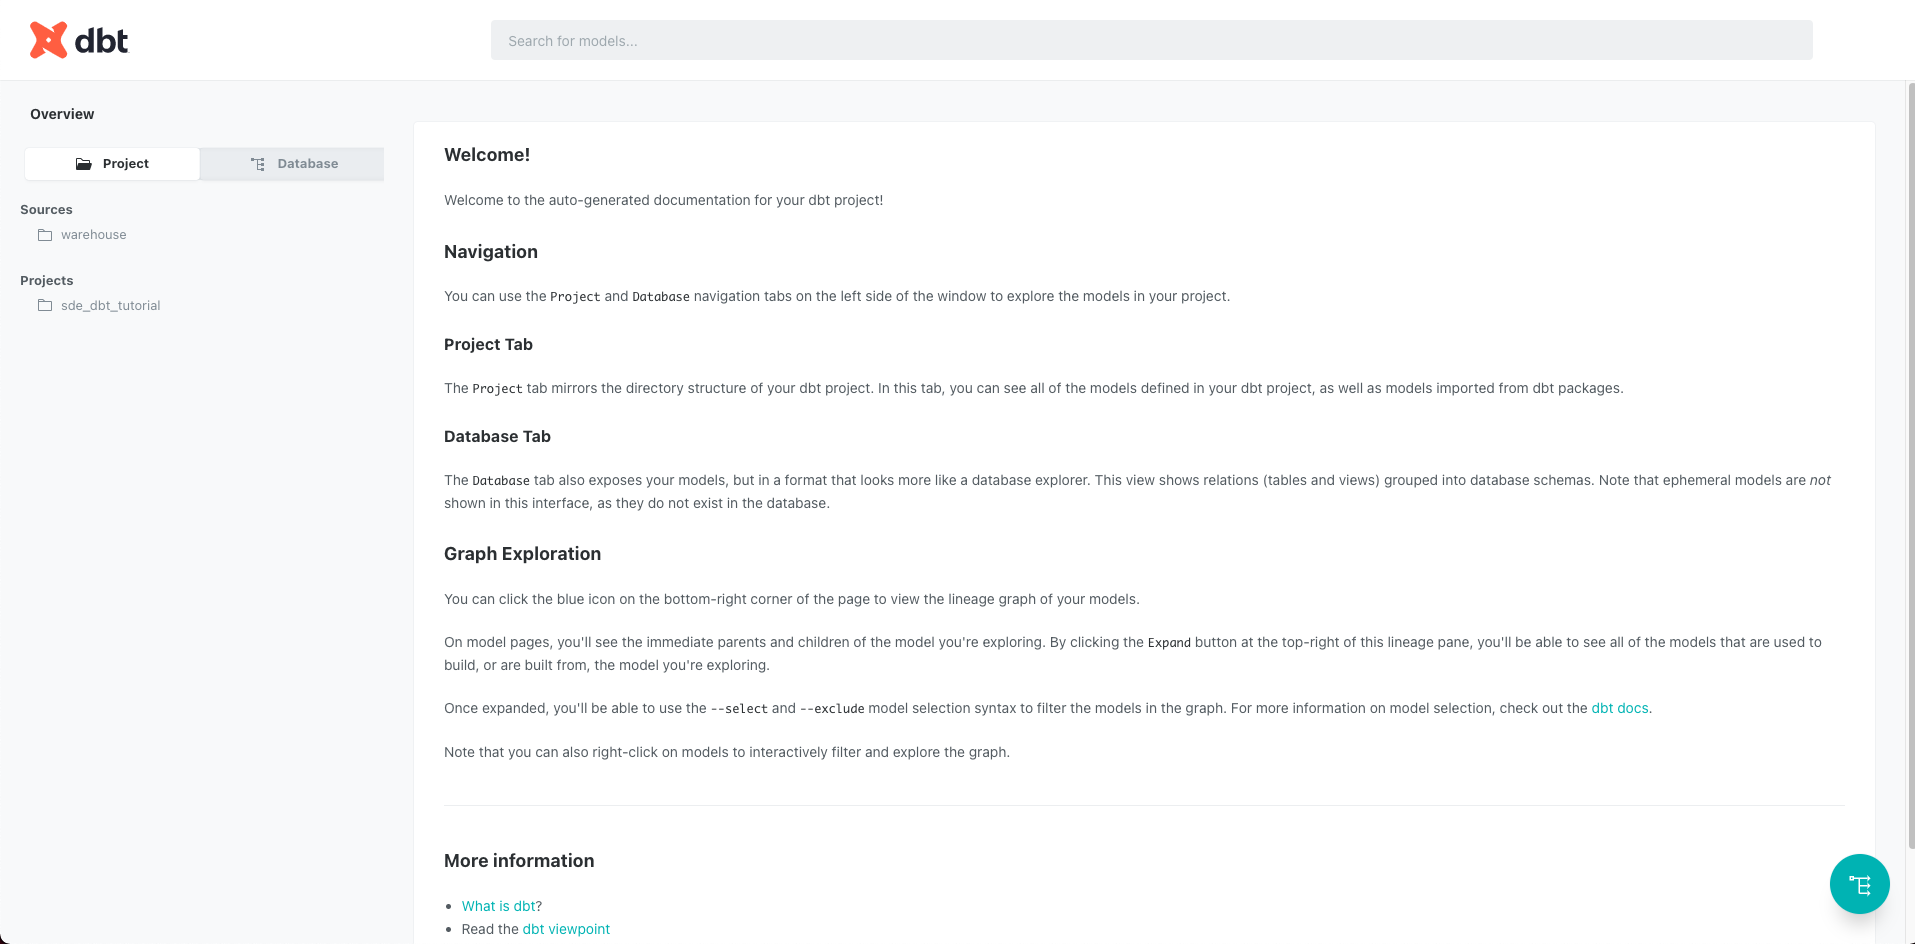

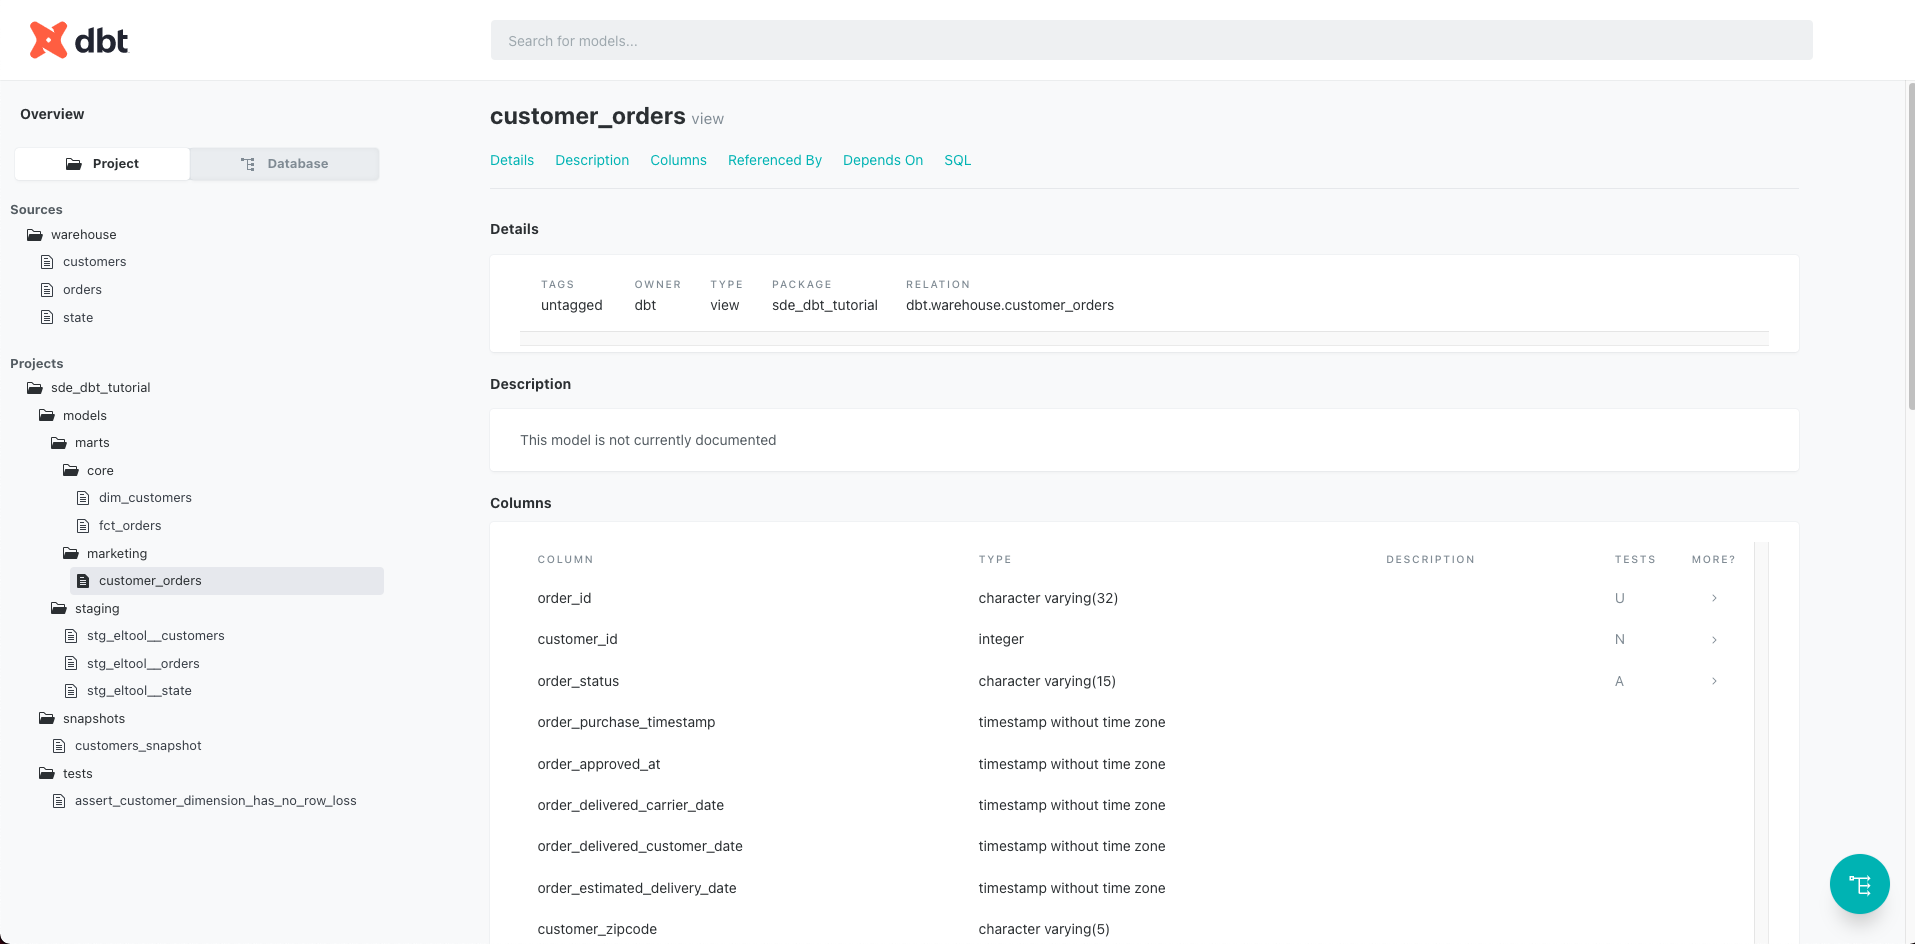

The lineage graph shows the dependencies of a model. You can also see the tests defined, descriptions (set in the corresponding YAML file), and the compiled sql statements.

![Lineage Graph](https://www.startdataengineering.com/images/dbt_tutorial/customer_orders_lg.png)

## Scheduling

We have seen how to create snapshots, models, run tests and generate documentation. These are all commands run via the cli. Dbt compiles the models into sql queries under the target folder (not part of git repo) and executes them on the data warehouse.

To schedule dbt runs, snapshots, and tests we need to use a scheduler. Dbt cloud is a great option to do easy scheduling. The dbt commands can be run by other popular schedulers like cron, Airflow, Dagster, etc.

## Conclusion

dbt is a great choice to build your ELT pipelines. Combining data warehouse best practices, testing, documentation, ease of use, data CI/CD, community support and a great cloud offering, dbt has set itself up as an essential tool for data engineers.

To recap, we went over:
1. Dbt project structure
2. Setting up connections
3. Generating SCD2 (aka snapshots) with dbt
4. Generating models following best practices
5. Testing models
6. Generating and viewing documentation